02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [65]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [66]:
# windows
if os.name == 'nt':
    path = '../../../data/processed/'
    modelpath = '../../src/models/nakagawa/'
else:
    if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
        path = '/kaggle/input/processed/'
        modelpath = '/kaggle/input/models/'



# FIXME: PATHを修正すること!!!!


In [67]:
# FIXME: PATH
# train_X_path = os.path.join(path,'processed20240618_train_X.csv')
# test_X_path =os.path.join(path,'processed20240618_test_X.csv')
# train_y_path = os.path.join(path,'processed20240618_train_y.csv')
# test_y_path =os.path.join(path,'processed20240618_test_y.csv')
train_path = os.path.join(path,'processed20240619-1_train.csv')
test_path = os.path.join(path,'processed20240619-1_test.csv')

In [68]:
# データの読み込み
# train_X = pd.read_csv(train_X_path)
# train_y = pd.read_csv(train_y_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 目的変数と説明変数の作成
# del train_X['target']
target = train['target']
del train['target']

In [69]:
# lightgbmのパラメータ
lgb_param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

# xgbmのパラメータ
xgb_params = {
    'objective': 'reg:squarederror',  # 回帰問題の場合は'reg:squarederror'を指定
    'eval_metric': 'rmse',  # 評価指標としてRMSEを使用
    'eta': 0.1,  # 学習率
    'max_depth': 3,  # 決定木の最大深度
    'subsample': 0.8,  # サンプルの割合
    'colsample_bytree': 0.8  # 特徴量の割合
}
# rfのパラメータ
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'criterion': ['squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [70]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['first_active_month','card_id']]
categorical_feats = ['feature_2', 'feature_3']

In [71]:

def train_model_with_random_search(model, param_grid,train,test, folds):
    rmse_scores = []
    best_params_list = []

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, test.values)):
        X_train_fold, X_val_fold = train.iloc[trn_idx][features], test.iloc[trn_idx]
        y_train_fold, y_val_fold = train.iloc[val_idx][features], test.iloc[val_idx]

        rf_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=2,
                                       cv=3, verbose=2, random_state=42, n_jobs=-1)

        rf_random.fit(X_train_fold, X_val_fold)
        best_params_list.append(rf_random.best_params_)

        y_pred_val = rf_random.predict(y_train_fold)
        rmse_scores.append(root_mean_squared_error(y_val_fold, y_pred_val, squared=False))

    best_params = get_most_frequent_params(best_params_list)

    rf_model = RandomForestRegressor(**best_params)
    rf_model.fit(X_train_fold, X_val_fold)

    y_pred_test = rf_model.predict(y_train_fold)
    rmse_test = root_mean_squared_error(y_val_fold, y_pred_test, squared=False)

    return rf_model, rmse_test, best_params

def get_most_frequent_params(param_list):
    param_count = {}
    for params in param_list:
        params_str = str(params)
        if params_str in param_count:
            param_count[params_str] += 1
        else:
            param_count[params_str] = 1
    most_frequent_params = max(param_count, key=param_count.get)
    return eval(most_frequent_params)



In [72]:
def model_learning(train,test,save_name,modelname):
    # データをKFoldで5分割して学習
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(train))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    if modelname == 'lgb':
        for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, test.values)):
            print("fold n°{}".format(fold_))
            trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                                label=test.iloc[trn_idx],
                                categorical_feature=categorical_feats
                                )
            val_data = lgb.Dataset(train.iloc[val_idx][features],
                                label=test.iloc[val_idx],
                                categorical_feature=categorical_feats
                                )

            num_round = 10000
            clf = lgb.train(params=lgb_param,
                            train_set=trn_data,
                            num_boost_round=num_round,
                            valid_sets=[val_data],
                            callbacks=[lgb.early_stopping(stopping_rounds=200),
                                    lgb.log_evaluation(100)])

            oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = features
            fold_importance_df["importance"] = clf.feature_importance()
            fold_importance_df["fold"] = fold_ + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            # モデルを保存
            if not os.path.exists(modelpath+save_name):
                os.makedirs(modelpath+save_name)
            with open(f'{modelpath}{save_name}/{save_name}_{fold_}.pkl', 'wb') as f:
                pickle.dump(clf, f)

    elif modelname == 'xgb':
        for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, test.values)):
            print("fold n°{}".format(fold_))
            trn_data = xgb.DMatrix(train.iloc[trn_idx][features],
                                label=test.iloc[trn_idx],
                                )
            val_data = xgb.DMatrix(train.iloc[val_idx][features],
                                label=test.iloc[val_idx],
                                )

            num_round = 10000
            early_stop = xgb.callback.EarlyStopping(rounds=200
                                        )
            # print_evaluation = xgb.callback.print_evaluation(period=100)
            clf = xgb.train(params=xgb_params,
                dtrain=trn_data,
                num_boost_round=num_round,
                evals=[(val_data, 'rsme')],
                callbacks = [early_stop]
                )

            oof[val_idx] = clf.predict(val_data)
            feature_importance_df = None
            # fold_importance_df = pd.DataFrame()
            # fold_importance_df["feature"] = features
            # fold_importance_df["importance"] = clf.feature_importance()
            # fold_importance_df["fold"] = fold_ + 1
            # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            # モデルを保存
            if not os.path.exists(modelpath+save_name):
                os.makedirs(modelpath+save_name)
            with open(f'{modelpath}{save_name}/{save_name}_{fold_}.pkl', 'wb') as f:
                pickle.dump(clf, f)
    elif modelname == 'rf':
        folds = KFold(n_splits=5, shuffle=True, random_state=42)

        model_rf = RandomForestRegressor()

        time_start = time.time()
        model_rf, rmse_rf, param_rf = train_model_with_random_search(model_rf, rf_param_grid,
                                                                            train,test, folds)
        time_taken_rf = time.time() - time_start
        oof[val_idx] = model_rf.predict(train.iloc[val_idx][features],params=param_rf)
        # モデルを保存
        if not os.path.exists(modelpath+save_name):
            os.makedirs(modelpath+save_name)
        with open(f'{modelpath}{save_name}/{save_name}_{fold_}.pkl', 'wb') as f:
            pickle.dump(model_rf, f)


    print("CV score: {:<8.5f}".format(root_mean_squared_error(oof, test)))
    return feature_importance_df

# モデルネームを修正すること！！！

In [73]:
# FIXME: train_Xデータの学習
# X_train_feature_importance_df = model_learning(train_X,train_y,'train_X_model_20240618')


# モデルネームを修正すること!!!!

In [74]:
# すべてのtrainデータの学習
feature_importance_df = model_learning(train,target,save_name='train_lgb_model_20240619-2',modelname='lgb')

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.77557
[200]	valid_0's rmse: 3.72712
[300]	valid_0's rmse: 3.70302
[400]	valid_0's rmse: 3.69054
[500]	valid_0's rmse: 3.68352
[600]	valid_0's rmse: 3.67912
[700]	valid_0's rmse: 3.67668
[800]	valid_0's rmse: 3.67444
[900]	valid_0's rmse: 3.67282
[1000]	valid_0's rmse: 3.67188
[1100]	valid_0's rmse: 3.67093
[1200]	valid_0's rmse: 3.67055
[1300]	valid_0's rmse: 3.67017
[1400]	valid_0's rmse: 3.67009
[1500]	valid_0's rmse: 3.67
[1600]	valid_0's rmse: 3.66985
[1700]	valid_0's rmse: 3.66988
[1800]	valid_0's rmse: 3.66998
Early stopping, best iteration is:
[1647]	valid_0's rmse: 3.66978
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7046
[200]	valid_0's rmse: 3.66072
[300]	valid_0's rmse: 3.64005
[400]	valid_0's rmse: 3.62939
[500]	valid_0's rmse: 3.6236
[600]	valid_0's rmse: 3.62055
[700]	valid_0's rmse: 3.61844
[800]	valid_0's rmse: 3.61678
[900]	va

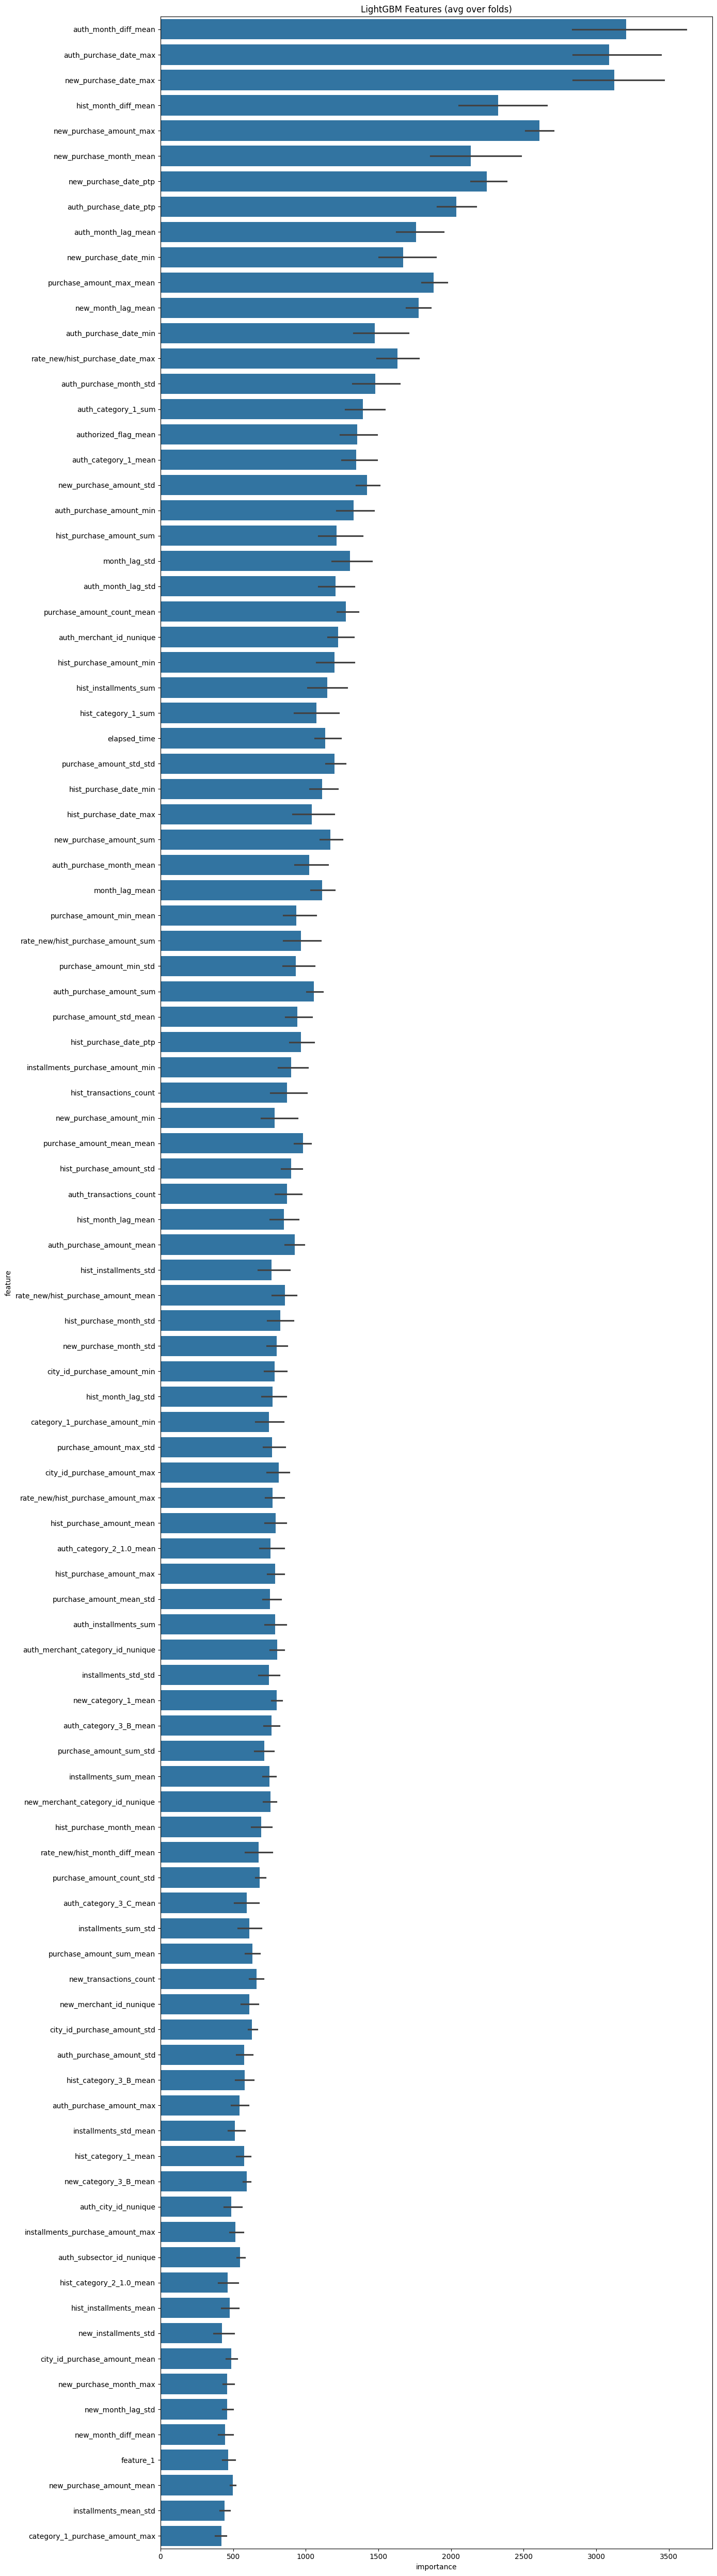

In [75]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')